## 02. Cluster analyses

In [1]:
import folium
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import geopandas
import shapely

In [2]:
dataset_chipotle = "./assets/chipotle_stores.csv"

# Load the dataset
chip = pd.read_csv(dataset_chipotle, sep = ',')

### Functions definitions

color palette

In [3]:
import random

def rand_255() -> int:
    """Generate a random number between 0 and 255."""
    return random.randint(0, 255)

# Init the color list
colors = []

# Populate the list with 200 random colors
for i in range(200):
    colors.append('#%02X%02X%02X' % (rand_255(), rand_255(), rand_255()))

In [4]:
def set_color(index: int) -> str:
    """Return the color corresponding to a given intex"""
    
    return colors[index]

Map printing

In [5]:
def display_map(dataframe: pd.DataFrame):
    
    # Create a folium map, centered on United States
    m = folium.Map(
        location=[37.6, -95.665],
        zoom_start=4,
        zoom_control=False,
        scrollWheelZoom=False,
        dragging=False
    )
    
    # Add the Starbucks as markers
    _ = dataframe.apply(lambda row: folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=1,
        weight=3,
        color=row['color'],
        fill_color=row['color']
    ).add_to(m), axis=1)
    
    return m

Evaluation

In [6]:
def distance_point_to_others(point):
    """
    Math the distance (similarity) between a point and every
    other points in the same cluster.
    """

### Cluster 

In [7]:
metrics = chip[['latitude','longitude']]

Right count of cluster, elbow method

In [8]:
# z-score normalisation
metrics_norms =(metrics-metrics.mean())/metrics.std()
metrics_norms = metrics_norms.rename(columns={'latitude': 'latitude_zscore', 'longitude':'longitude_zscore'})

In [9]:
chip[['latitude_zscore','longitude_zscore']]=metrics_norms

In [10]:
chip

state          location  \
0          Alabama            Auburn   
1          Alabama        Birmingham   
2          Alabama        Birmingham   
3          Alabama        Birmingham   
4          Alabama           Cullman   
...            ...               ...   
2624     Wisconsin  Pleasant Prairie   
2625     Wisconsin         Wauwatosa   
2626  North Dakota             Fargo   
2627  North Dakota             Fargo   
2628       Wyoming          Cheyenne   

                                             address   latitude   longitude  \
0             346 W Magnolia Ave Auburn, AL 36832 US  32.606813  -85.487328   
1              300 20th St S Birmingham, AL 35233 US  33.509721  -86.802756   
2             3220 Morrow Rd Birmingham, AL 35235 US  33.595581  -86.647437   
3           4719 Highway 280 Birmingham, AL 35242 US  33.422582  -86.698279   
4          1821 Cherokee Ave SW Cullman, AL 35055 US  34.154134  -86.841220   
...                                              ...        ...         ...   
2624  9370 76th St # B Pleasant Prairie, WI 53158 US  42.565892  -87.921048   
2625  2711 N Mayfair Rd Ste A Wauwatosa, WI 53222 US  43.067723  -88.048222   
2626              1204 19th Ave N Fargo, ND 58102 US  46.904247  -96.796618   
2627               1680 45th St S Fargo, ND 58103 US  46.855337  -96.861416   
2628      1508 Dell Range Blvd Cheyenne, WY 82009 US  41.160718 -104.805699   

      latitude_zscore  longitude_zscore  
0           -1.033707          0.422409  
1           -0.843584          0.343064  
2           -0.825505          0.352433  
3           -0.861933          0.349366  
4           -0.707893          0.340744  
...               ...               ...  
2624         1.063343          0.275610  
2625         1.169012          0.267939  
2626         1.976856         -0.259752  
2627         1.966558         -0.263661  
2628         0.767461         -0.742849  

[2629 rows x 7 columns]

In [11]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(60,80)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km = km.fit(metrics_norms)
    Sum_of_squared_distances.append(km.inertia_)

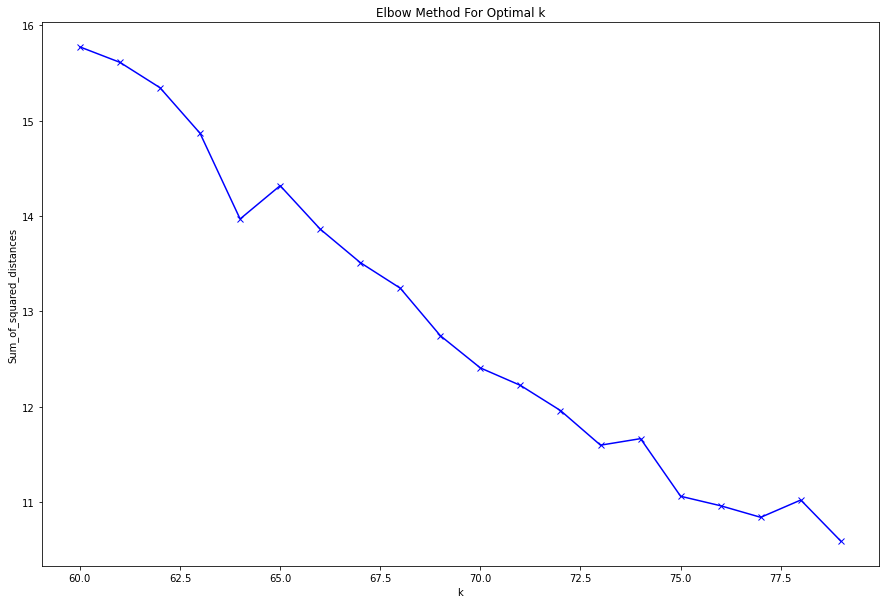

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### k_means

In [13]:
from sklearn.cluster import KMeans

# Create a KMeans object
kmeans = KMeans(n_clusters=19, init='k-means++', random_state=42)

# Cluster the data
kmeans.fit(metrics_norms)

KMeans(n_clusters=19, random_state=42)

In [14]:
kmeans.cluster_centers_
kmeans.labels_
kmeans.n_iter_
kmeans.inertia_

86.84222434319037

In [15]:
k_means_chip = chip

cluster_labels = pd.Series(kmeans.labels_, name='K_means_cluster')
k_means_chip = k_means_chip.join(cluster_labels.to_frame())
k_means_chip['color'] = k_means_chip['K_means_cluster'].apply(set_color)

In [16]:
k_means_chip

state          location  \
0          Alabama            Auburn   
1          Alabama        Birmingham   
2          Alabama        Birmingham   
3          Alabama        Birmingham   
4          Alabama           Cullman   
...            ...               ...   
2624     Wisconsin  Pleasant Prairie   
2625     Wisconsin         Wauwatosa   
2626  North Dakota             Fargo   
2627  North Dakota             Fargo   
2628       Wyoming          Cheyenne   

                                             address   latitude   longitude  \
0             346 W Magnolia Ave Auburn, AL 36832 US  32.606813  -85.487328   
1              300 20th St S Birmingham, AL 35233 US  33.509721  -86.802756   
2             3220 Morrow Rd Birmingham, AL 35235 US  33.595581  -86.647437   
3           4719 Highway 280 Birmingham, AL 35242 US  33.422582  -86.698279   
4          1821 Cherokee Ave SW Cullman, AL 35055 US  34.154134  -86.841220   
...                                              ...        ...         ...   
2624  9370 76th St # B Pleasant Prairie, WI 53158 US  42.565892  -87.921048   
2625  2711 N Mayfair Rd Ste A Wauwatosa, WI 53222 US  43.067723  -88.048222   
2626              1204 19th Ave N Fargo, ND 58102 US  46.904247  -96.796618   
2627               1680 45th St S Fargo, ND 58103 US  46.855337  -96.861416   
2628      1508 Dell Range Blvd Cheyenne, WY 82009 US  41.160718 -104.805699   

      latitude_zscore  longitude_zscore  K_means_cluster    color  
0           -1.033707          0.422409                5  #0A4953  
1           -0.843584          0.343064                5  #0A4953  
2           -0.825505          0.352433                5  #0A4953  
3           -0.861933          0.349366                5  #0A4953  
4           -0.707893          0.340744                5  #0A4953  
...               ...               ...              ...      ...  
2624         1.063343          0.275610                7  #7A50AB  
2625         1.169012          0.267939                7  #7A50AB  
2626         1.976856         -0.259752               14  #2F553E  
2627         1.966558         -0.263661               14  #2F553E  
2628         0.767461         -0.742849                9  #E3E5DF  

[2629 rows x 9 columns]

In [17]:
display_map(k_means_chip)

### Mean shift

In [18]:
from sklearn.cluster import MeanShift

# Create a MeanShift object
mean_shift = MeanShift()

# Cluster the data
mean_shift.fit(metrics_norms)

MeanShift()

In [19]:
Mean_shift_chip = chip

cluster_labels = pd.Series(mean_shift.labels_, name='Mean_shift_cluster')
Mean_shift_chip = Mean_shift_chip.join(cluster_labels.to_frame())
Mean_shift_chip['color'] = Mean_shift_chip['Mean_shift_cluster'].apply(set_color)

In [20]:
mean_shift.cluster_centers_
mean_shift.labels_
mean_shift.n_iter_

11

In [21]:
display_map(Mean_shift_chip)

### Agglomerative Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering

# Create an Agglomerative Clustering object
agglomerative = AgglomerativeClustering(n_clusters=60, linkage='ward')

# Cluster the data
agglomerative.fit(metrics_norms)

AgglomerativeClustering(n_clusters=60)

In [23]:
agglomerative.n_clusters_
agglomerative.labels_ 
agglomerative.n_leaves_
agglomerative.n_connected_components_
agglomerative.children_

array([[2179, 2180],
       [  98,   99],
       [1656, 1683],
       ...,
       [5237, 5249],
       [5252, 5254],
       [5253, 5255]], dtype=int64)

In [26]:
agglomerative_chip = chip

cluster_labels = pd.Series(agglomerative.labels_, name='Agglomerative_cluster')
agglomerative_chip = agglomerative_chip.join(cluster_labels.to_frame())
agglomerative_chip['color'] = agglomerative_chip['Agglomerative_cluster'].apply(set_color)

In [27]:
display_map(agglomerative_chip)

In [28]:
import numpy as np
import pandas as pd 

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
# from scipy.spatial.distance import 

from pylab import rcParams
import seaborn as sns 
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import  AgglomerativeClustering
import sklearn.metrics as ms

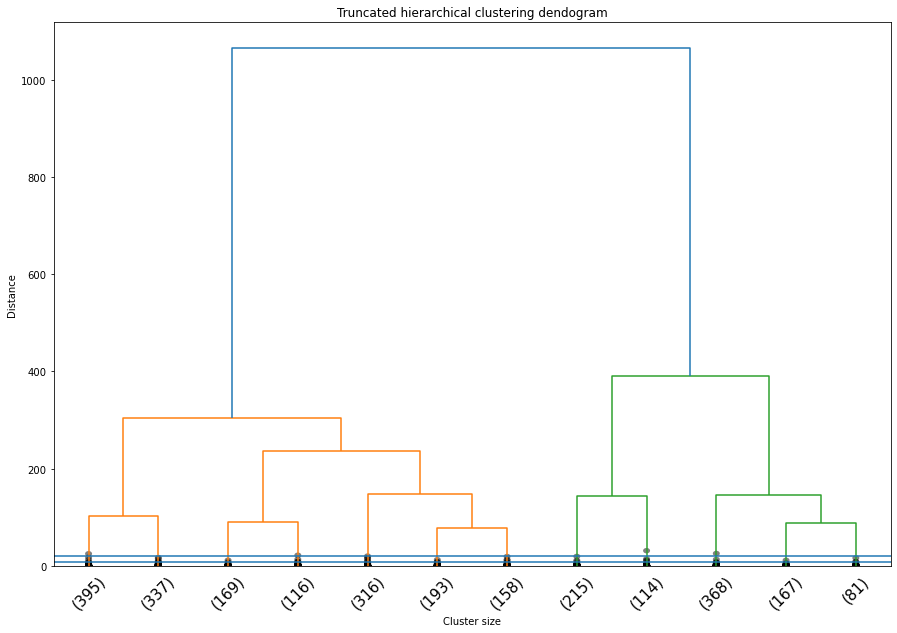

In [29]:
# using scipy to generate dendogram
Z=linkage(metrics, 'ward')

fig, ax = plt.subplots(figsize=(15, 10))
# dn1 = hierarchy.dendrogram(Z, ax=ax, above_threshold_color='y', orientation='top')

dendrogram(Z, truncate_mode='lastp',ax=ax, p=12, orientation='top', leaf_rotation=45, leaf_font_size=15, show_contracted=True)

plt.title('Truncated hierarchical clustering dendogram')

plt.xlabel('Cluster size')
plt.ylabel('Distance')

plt.axhline(y=20)
plt.axhline(y=7)
plt.grid
plt.show()